## Setup

In [1]:
!pip uninstall tensorflow -y
!pip install  tensorflow==2.15.0

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
keras = tf.keras

2.15.0


In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(32).prefetch(1)

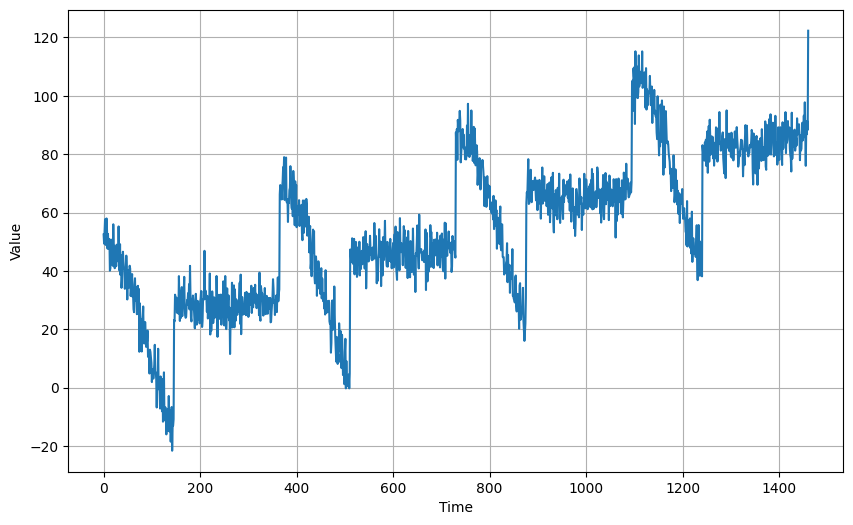

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

## LSTM RNN Forecasting

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=10e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 10s 84ms/step - loss: 21.3458 - mae: 21.8444 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 3s 104ms/step - loss: 20.5553 - mae: 21.0534 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 3s 82ms/step - loss: 19.7848 - mae: 20.2828 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 2s 64ms/step - loss: 19.1197 - mae: 19.6157 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 1s 35ms/step - loss: 18.5985 - mae: 19.0950 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 2s 47ms/step - loss: 18.1855 - mae: 18.6800 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 2s 62ms/step - loss: 17.8870 - mae: 18.3816 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 1s 41ms/step - loss: 17.6686 - mae: 18.1632 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 1s 36ms/step - loss: 17.4822 - ma

(1e-08, 0.0001, 0.0, 30.0)

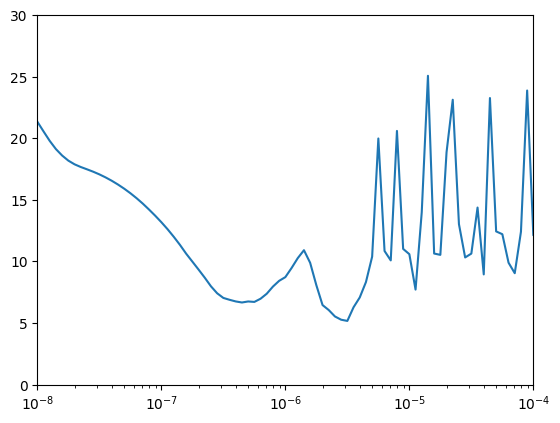

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
33/33 [==============================] - 7s 84ms/step - loss: 17.8441 - mae: 18.3371 - val_loss: 17.6702 - val_mae: 18.1627
Epoch 2/500
33/33 [==============================] - 1s 44ms/step - loss: 9.6024 - mae: 10.0940 - val_loss: 11.3277 - val_mae: 11.8239
Epoch 3/500
33/33 [==============================] - 2s 49ms/step - loss: 7.2766 - mae: 7.7590 - val_loss: 11.0154 - val_mae: 11.5100
Epoch 4/500
33/33 [==============================] - 2s 49ms/step - loss: 7.0168 - mae: 7.4972 - val_loss: 10.1571 - val_mae: 10.6480
Epoch 5/500
33/33 [==============================] - 2s 53ms/step - loss: 7.0731 - mae: 7.5557 - val_loss: 9.4553 - val_mae: 9.9464
Epoch 6/500
33/33 [==============================] - 3s 89ms/step - loss: 6.6543 - mae: 7.1368 - val_loss: 8.3113 - val_mae: 8.7983
Epoch 7/500
33/33 [==============================] - 2s 48ms/step - loss: 6.7635 - mae: 7.2470 - val_loss: 7.1252 - val_mae: 7.6108
Epoch 8/500
33/33 [==============================] - 2s 49ms/step

In [47]:
model = keras.models.load_model("my_checkpoint.h5")

In [51]:
rnn_forecast = []
for time in range(len(x_valid) - window_size+30):
    forecast = model.predict(x_valid[time:time + window_size][np.newaxis])
    rnn_forecast.append(forecast)

rnn_forecast = np.array(rnn_forecast)[:, 0, 0]
print("Shape of time_valid:", time_valid.shape)
print("Shape of rnn_forecast:", rnn_forecast.shape)

1/1 [==============================] - 0s 33ms/step
Shape of time_valid: (461,)
Shape of rnn_forecast: (461,)


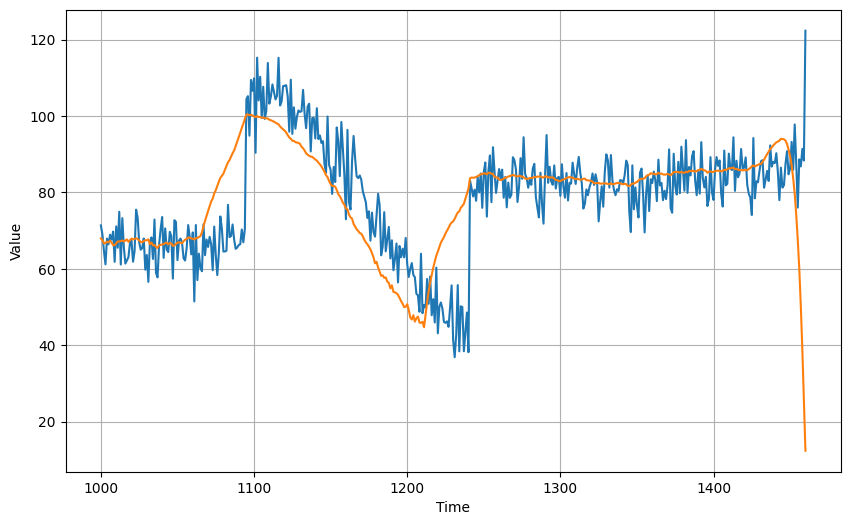

In [52]:

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [53]:
mae = keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
print(f"MAE: {mae}")

MAE: 8.016986846923828
